<a href="https://colab.research.google.com/github/fpgmina/stochastic_simulation/blob/main/CauchyApproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running Cauchy (α=1.0) convergence study...
N=20001 | h=0.25000 | MAE=8.86e-06 | Time=0.01s
N=40001 | h=0.12500 | MAE=1.91e-06 | Time=0.01s
N=80001 | h=0.06250 | MAE=5.17e-07 | Time=0.02s
N=100001 | h=0.05000 | MAE=3.31e-07 | Time=0.06s


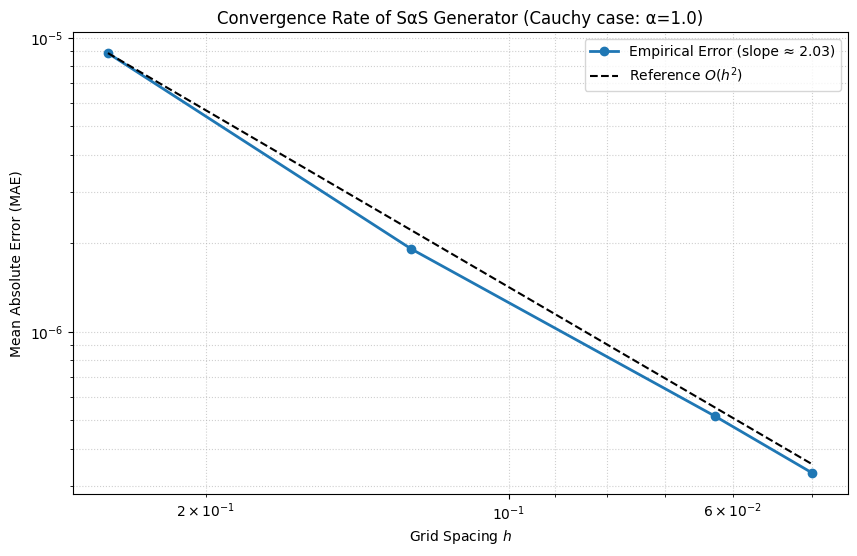

In [42]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dst
from scipy.stats import linregress

# ================================================================
# 1. Helper Functions
# ================================================================

def get_analytic_eigenvalues(N, h):
    """
    Compute the eigenvalues of the 1D Laplacian on a uniform grid with absorbing boundaries.

    Memory-efficient: O(N) memory usage.

    Parameters
    ----------
    N : int
        Number of interior grid points.
    h : float
        Grid spacing.

    Returns
    -------
    np.ndarray
        Analytic eigenvalues of size N.
    """
    M = N + 1.0
    k = np.arange(1, N + 1)
    return (1.0 / h**2) * (np.cos(k * np.pi / M) - 1.0)


def get_eigenvector_row(row_idx, N):
    """
    Compute a single row of the eigenvector matrix V for the 1D Laplacian.

    Each eigenvector is a sine function because of Dirichlet (zero) boundary
    conditions. This row will later be used in the Discrete Sine Transform (DST)
    to efficiently compute the density without forming the full NxN matrix.

    Memory-efficient: O(N) memory usage.

    Parameters
    ----------
    row_idx : int
        0-based index of the row to compute.
    N : int
        Number of interior grid points.

    Returns
    -------
    np.ndarray
        The requested row of the eigenvector matrix.
    """
    M = N + 1.0
    i = row_idx + 1.0  # Convert 0-based index to 1-based
    k = np.arange(1, N + 1)
    return np.sqrt(2.0 / M) * np.sin(i * k * np.pi / M)


def get_density_vector(prob_mass_vector, h):
    """
    Convert a probability mass vector to a probability density vector.

    Parameters
    ----------
    prob_mass_vector : np.ndarray
        Vector of probability masses.
    h : float
        Grid spacing.

    Returns
    -------
    np.ndarray
        Probability density vector.
    """
    return prob_mass_vector / h


def analytic_cauchy_density(x, t, c_analytic):
    """
    Analytic PDF of the symmetric Cauchy process (α=1).

    Parameters
    ----------
    x : np.ndarray
        Grid points.
    t : float
        Time horizon.
    c_analytic : float
        Scale parameter for the analytic Cauchy distribution.

    Returns
    -------
    np.ndarray
        Probability density values at the grid points.
    """
    gamma = c_analytic * t
    return (1.0 / np.pi) * (gamma / (gamma**2 + x**2))


# ================================================================
# 2. Simulation Parameters
# ================================================================

L = 5000.0             # Domain size [-L/2, L/2]
t = 1                  # Time horizon

alpha_stable = 1.0     # α = 1 for Cauchy
scale_c_generator = 0.5
scale_c_analytic = scale_c_generator * 2**(-alpha_stable / 2.0)

N_values = [20001, 40001, 80001, 100001]  # Grid resolutions for convergence study

# ================================================================
# 3. Convergence Study: Error vs. Grid Spacing
# ================================================================

h_values = []
error_values = []

print(f"Running Cauchy (α={alpha_stable}) convergence study...")

for N in N_values:
    start_time = time.time()

    # --- 3a. Grid setup ---
    h = L / (N - 1)
    grid = np.linspace(-L / 2, L / 2, N)
    center_idx = N // 2  # Index corresponding to x=0

    # --- 3b. Eigenvalues and subordination ---
    laplace_eig = get_analytic_eigenvalues(N, h)  # O(N) memory
    stable_mu = -scale_c_generator * ((-laplace_eig) ** (alpha_stable / 2.0))
    p_k = np.exp(stable_mu * t)

    # --- 3c. Density computation via single DST row ---
    v_center = get_eigenvector_row(center_idx, N)
    w = v_center * p_k

    # Compute probability masses using the Discrete Sine Transform (DST)
    # ---------------------------------------------------------------
    # The DST (type-I) efficiently computes the sum over all eigenvectors
    # weighted by the transition probabilities p_k. Conceptually, this is:
    #    prob_mass_vector = V diag(p_k) V.T
    #    prob_mass_vector[i] = sum_k v_i[k] * p_k * v_k
    # where v_i[k] is the i-th row of the eigenvector matrix and v_k the eigenvectors.
    #
    # Since the eigenvectors of the 1D Laplacian with Dirichlet boundary conditions
    # are sine functions, the DST is exactly the fast way to perform this sum.
    # This avoids forming the full NxN matrix and runs in O(N log N) time.
    M = N + 1.0
    prob_mass = (1.0 / np.sqrt(2.0 * M)) * dst(w, type=1)

    approx_pdf = get_density_vector(prob_mass, h)

    # --- 3d. Analytic density ---
    true_pdf = analytic_cauchy_density(grid, t, scale_c_analytic)

    # --- 3e. Mean Absolute Error ---
    mae = np.mean(np.abs(approx_pdf - true_pdf))
    h_values.append(h)
    error_values.append(mae)

    elapsed = time.time() - start_time
    print(f"N={N:5} | h={h:.5f} | MAE={mae:.2e} | Time={elapsed:.2f}s")

# ================================================================
# 4. Log-Log Convergence Plot
# ================================================================

h_values = np.array(h_values)
error_values = np.array(error_values)

# Linear regression in log-log space
slope_result = linregress(np.log(h_values), np.log(error_values))
slope = slope_result.slope

# Reference O(h^2) line for visual comparison
ref_line = (error_values[0] / (h_values[0] ** 2)) * (h_values ** 2)

plt.figure(figsize=(10, 6))
plt.loglog(h_values, error_values, "o-", label=f"Empirical Error (slope ≈ {slope:.2f})", linewidth=2)
plt.loglog(h_values, ref_line, "k--", label="Reference $O(h^2)$")
plt.title(f"Convergence Rate of SαS Generator (Cauchy case: α={alpha_stable})")
plt.xlabel("Grid Spacing $h$")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True, which="both", linestyle=":", alpha=0.6)
plt.gca().invert_xaxis()  # Show convergence as h → 0
plt.show()


In [41]:
0.5 ** 2

0.25

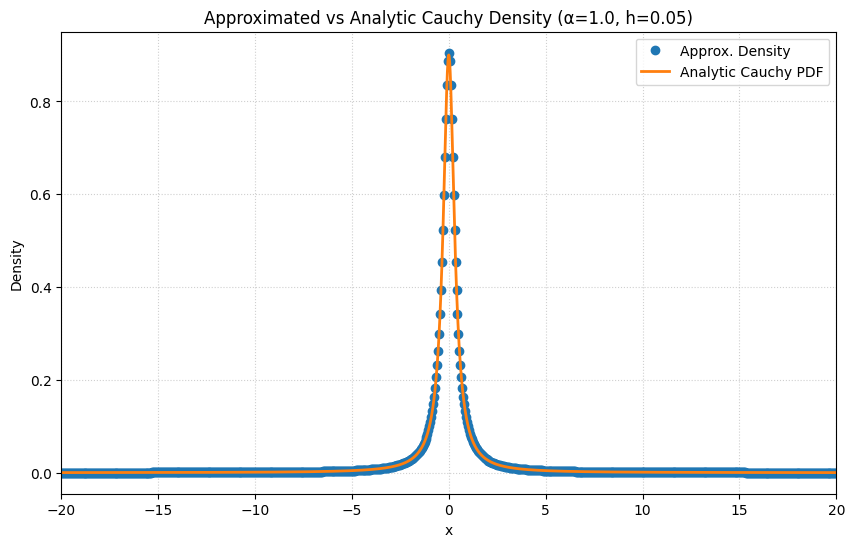

In [54]:
# ================================================================
# 5. Plot Approximated PDF vs Analytic Cauchy PDF
# ================================================================
L = 500
# Choose the largest N for best approximation
N = 10001  #N_values[-1]
h = L / (N - 1)
grid = np.linspace(-L / 2, L / 2, N)
center_idx = N // 2

# Compute approximate density (same as in convergence loop)
laplace_eig = get_analytic_eigenvalues(N, h)
stable_mu = -scale_c_generator * ((-laplace_eig) ** (alpha_stable / 2.0))
p_k = np.exp(stable_mu * t)

v_center = get_eigenvector_row(center_idx, N)
w = v_center * p_k
M = N + 1.0
prob_mass = (1.0 / np.sqrt(2.0 * M)) * dst(w, type=1)
approx_pdf = get_density_vector(prob_mass, h)

# Compute analytic Cauchy density
grid_true_pdf = np.linspace(-L / 2, L / 2, 100_000)
true_pdf = analytic_cauchy_density(grid_true_pdf, t, scale_c_analytic)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(grid, approx_pdf, "o", label="Approx. Density", linewidth=2)
plt.plot(grid_true_pdf, true_pdf, label="Analytic Cauchy PDF", linewidth=2)
plt.xlim(-20, 20)  # zoom around center for clarity
plt.xlabel("x")
plt.ylabel("Density")
plt.title(f"Approximated vs Analytic Cauchy Density (α={alpha_stable}, h={h})")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.show()


In [40]:
np.mean(np.abs(approx_pdf - true_pdf))

np.float64(1.1506134408488584e-06)